In [1]:
import os

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from IPython.display import display, HTML

display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))
plt.style.use("dark_background")

In [2]:
root_dir = ".."

In [3]:
admin = gpd.read_parquet(os.path.join(root_dir, "results/input/admin-boundaries/admin-level-0.geoparquet"))
admin.geometry = admin.geometry.boundary
admin.geometry = admin.geometry.simplify(tolerance=0.1)

In [4]:
edges = gpd.read_parquet(os.path.join(root_dir, "results/flow_allocation/edges_with_flows.gpq"))
edges[edges.volume_tons != 0]

,from_id,to_id,from_iso_a3,to_iso_a3,mode,cost_USD_t,geometry,value_kusd,volume_tons
561,port111_land,road_thailand-latest_28_8797,THA,THA,maritime_road,4.0,"LINESTRING (100.57530 13.70370, 100.57849 13.6...",1.477328e+02,467.698618
981,road_thailand-latest_36_1671,rail_thailand-latest_36_15,THA,THA,road_rail,5.0,"LINESTRING (101.59614 14.86133, 101.59381 14.8...",3.861913e+03,2010.143594
1132,road_thailand-latest_28_8797,port111_land,THA,THA,maritime_road,4.0,"LINESTRING (100.57530 13.70370, 100.57849 13.6...",1.526746e+06,841617.733076
1133,road_thailand-latest_27_525,port701_land,THA,THA,maritime_road,4.0,"LINESTRING (101.14215 12.68571, 101.14611 12.6...",1.839568e+04,10148.765729
1134,road_thailand-latest_9_2145,port904_land,THA,THA,maritime_road,4.0,"LINESTRING (98.40475 7.82368, 98.40019 7.81422)",9.034517e+04,52221.161491
...,...,...,...,...,...,...,...,...,...
340312,port1291_land,GID_0_VNM,VNM,VNM,imaginary,1000000.0,"LINESTRING (106.76615 10.73624, 107.86375 15.9...",4.926356e+05,269162.551180
340321,port1099_land,GID_0_ZAF,ZAF,ZAF,imaginary,1000000.0,"LINESTRING (32.03937 -28.79240, 26.12805 -28.4...",1.034834e+06,602236.552473
340555,port1086_land,GID_0_MMR,MMR,MMR,imaginary,1000000.0,"LINESTRING (96.21278 16.71605, 95.92710 19.25866)",5.693771e+01,154.263193
341936,GID_0_KHM,port535_land,KHM,KHM,imaginary,1000000.0,"LINESTRING (103.52746 10.67900, 105.13276 12.5...",1.622310e+02,93.986503


Text(0, 0.5, 'Frequency')

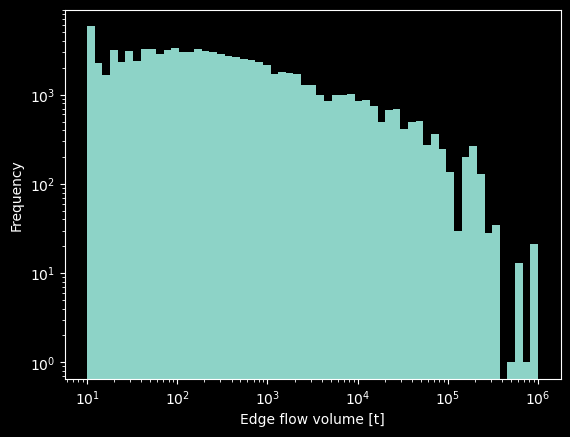

In [5]:
f, ax = plt.subplots()
min_non_zero = edges[edges.volume_tons != 0].volume_tons.min()
min_base_10_exp = int(np.floor(np.log10(min_non_zero)))
max_base_10_exp = int(np.ceil(np.log10(edges.volume_tons.max())))
ax.hist(
    edges.volume_tons,
    bins=np.logspace(
        min_base_10_exp,
        max_base_10_exp,
        60
    )
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Edge flow volume [t]")
ax.set_ylabel("Frequency")

In [6]:
edges

,from_id,to_id,from_iso_a3,to_iso_a3,mode,cost_USD_t,geometry,value_kusd,volume_tons
0,rail_thailand-latest_9_0,road_thailand-latest_9_1665,THA,THA,road_rail,5.0,"LINESTRING (99.19942 9.27534, 99.19297 9.26817)",0.0,0.0
1,rail_thailand-latest_9_1,road_thailand-latest_9_2941,THA,THA,road_rail,5.0,"LINESTRING (99.16463 9.20878, 99.16868 9.22313)",0.0,0.0
2,rail_thailand-latest_9_2,road_thailand-latest_9_1654,THA,THA,road_rail,5.0,"LINESTRING (99.20162 9.12104, 99.20061 9.12588)",0.0,0.0
3,rail_thailand-latest_9_3,road_thailand-latest_9_2009,THA,THA,road_rail,5.0,"LINESTRING (99.23042 9.10415, 99.23311 9.10721)",0.0,0.0
4,rail_thailand-latest_9_4,road_thailand-latest_9_2669,THA,THA,road_rail,5.0,"LINESTRING (99.25600 9.05591, 99.25385 9.05877)",0.0,0.0
...,...,...,...,...,...,...,...,...,...
342083,GID_0_TGO,port1468_land,TGO,TGO,imaginary,1000000.0,"LINESTRING (1.51715 6.19971, 1.04390 8.62082)",0.0,0.0
342084,GID_0_TUN,port1469_land,TUN,TUN,imaginary,1000000.0,"LINESTRING (10.29890 36.81202, 8.89768 33.79127)",0.0,0.0
342085,GID_0_TUN,port1470_land,TUN,TUN,imaginary,1000000.0,"LINESTRING (10.09644 34.28748, 8.89768 33.79127)",0.0,0.0
342086,GID_0_COG,port1471_land,COG,COG,imaginary,1000000.0,"LINESTRING (11.92841 -4.91988, 16.06371 -0.66906)",0.0,0.0


       volume_t_km
mode              
rail  6.397393e+06
road  6.960034e+09


Text(0, 0.5, 'Volume [t] / Distance [km]')

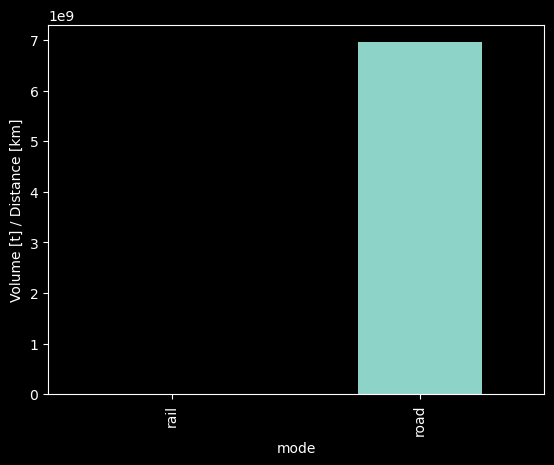

In [7]:
land_mask = edges["mode"].isin(("road", "rail"))
land = edges.loc[land_mask].copy()
land["distance_km"] = land["geometry"].to_crs(land.estimate_utm_crs()).length / 1000
land["volume_t_km"] = land.volume_tons / land.distance_km

modal_split = land.loc[:, ["volume_t_km"]].groupby(land["mode"]).sum()
print(modal_split)
f, ax = plt.subplots()
modal_split.volume_t_km.plot(kind="bar", ax=ax)
ax.set_ylabel("Volume [t] / Distance [km]")

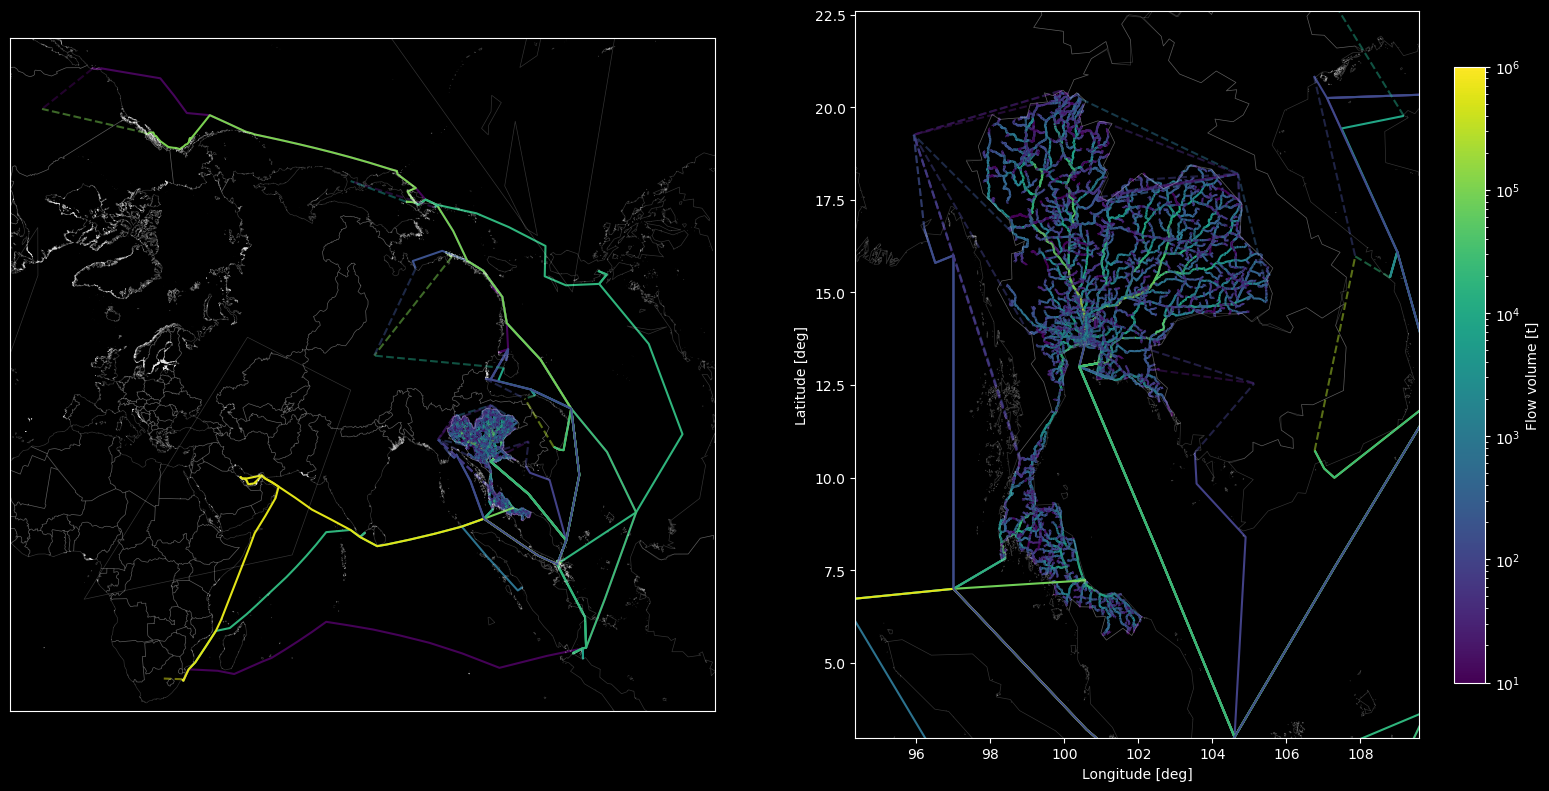

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 16))

to_plot = edges[edges.volume_tons != 0]
not_imaginary_mask = to_plot["mode"] != "imaginary"

norm = LogNorm(10**min_base_10_exp, 10**max_base_10_exp)
orthographic_proj: int = 9840

to_plot[not_imaginary_mask].to_crs(epsg=orthographic_proj).plot("volume_tons", ax=ax1, norm=norm)
to_plot[~not_imaginary_mask].to_crs(epsg=orthographic_proj).plot("volume_tons", ax=ax1, norm=norm, ls="--", alpha=0.5)
xmin, xmax = ax1.get_xlim()
ymin, ymax = ax1.get_ylim()
admin.to_crs(epsg=orthographic_proj).plot(ax=ax1, lw=0.5, alpha=0.2)
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

to_plot[not_imaginary_mask].plot("volume_tons", ax=ax2, legend=True, norm=norm, legend_kwds={"shrink": 0.5, "label": "Flow volume [t]"})
to_plot[~not_imaginary_mask].plot("volume_tons", ax=ax2, norm=norm, ls="--", alpha=0.5)
admin.plot(ax=ax2, lw=0.5, alpha=0.2)
ax2.set_xlim(94.35, 109.59)
ax2.set_ylim(2.98, 22.59)
ax2.set_xlabel("Longitude [deg]")
ax2.set_ylabel("Latitude [deg]")
f.savefig("trade_flow_allocation.png")